In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import os
import mne
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix
import tensorflow
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Dense, Activation, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Flatten, Dropout, BatchNormalization, Input,UpSampling1D
from tensorflow.keras.layers import concatenate, Lambda, Conv2D, MaxPooling2D, GlobalAveragePooling2D,LSTM
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

c:\Users\ryoii\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\ryoii\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
from __00_load_csv import load_alphabet
from __01_transform_data import transform_eeg_data, process_band, MA_X, MA_X2, apply_filter
from __02_model import train, visualize, plot_confusion_matrix, evaluate
from __03_utils import plot_eeg, downsample, plot_eeg_1280
from __04_DomainAdaptation import class_conditional_domain_adaptation

Downsampling EEG Data: 100%|██████████| 220/220 [00:00<00:00, 4343.81it/s]


shape of X_VIE : (220, 2, 1280)
shape of Y_VIE : (220,)


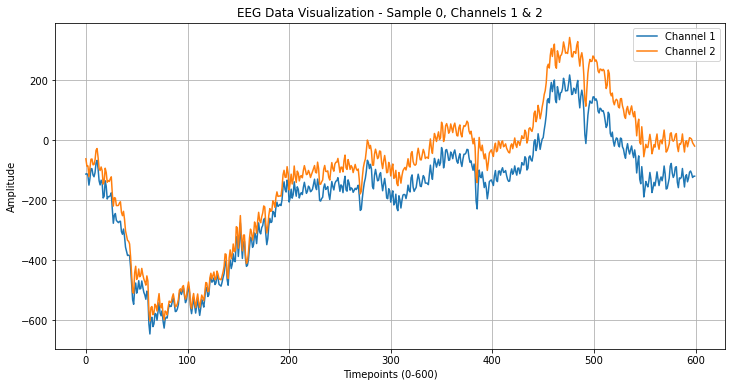

In [3]:
parent_dir = os.path.dirname(os.getcwd())
fo = os.path.join(parent_dir, 'data', 'Vie2Image', 'Char')
os.chdir(parent_dir)

x, Y_VIE = load_alphabet(fo)
X_VIE = downsample(x)

print(f'shape of X_VIE : {X_VIE.shape}')
print(f'shape of Y_VIE : {Y_VIE.shape}')

plot_eeg_1280(X_VIE)
# transform to power and use brainwave data in between 4 to 40 hZ

shape of X_VIE : (220, 2, 1280)


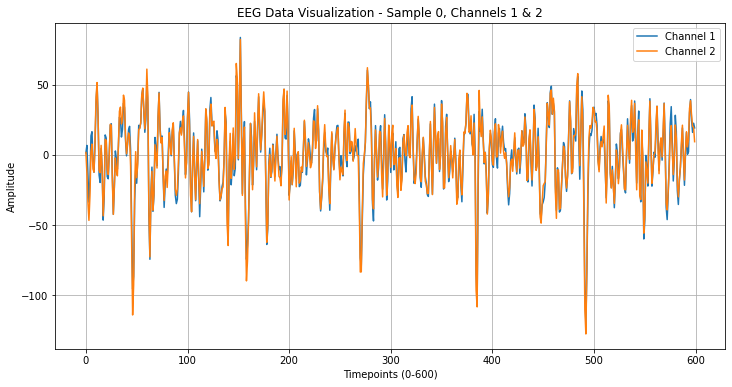

[  1.37376908   6.72309519 -13.2637642  ... -39.04391985 -27.28984481
  -1.49567603]
[  1.62115947 -12.86813104 -33.72365888 ... -42.69625963 -24.35117445
  -0.19243607]


In [4]:
vie_filtered = apply_filter(X_VIE, 4, 40, 128)
print(f'shape of X_VIE : {vie_filtered.shape}')
plot_eeg_1280(vie_filtered)

print(vie_filtered[0,0,:])
print(vie_filtered[0,1,:])


In [ ]:
from __00_load_edf import load_alphabet

fo = os.path.join(parent_dir, 'data', 'Envisioned_Speech_Recognition', 'Char')
x, Y_EMOTIV, channels = load_alphabet(fo)
selected_channels = [4,9]
X_EMOTIV = x[:,selected_channels,:]

print(f'shape of X_EMOTIV : {X_EMOTIV.shape}')
print(f'shape of Y_EMOTIV : {Y_EMOTIV.shape}')


In [ ]:
# 事前にデータセットをスプリットしないといけない
def normalize(data):
    mean = np.mean(data, axis=(0, 2), keepdims=True)
    std = np.std(data, axis=(0, 2), keepdims=True)
    return (data - mean) / std

X_VIE = normalize(X_VIE)
X_EMOTIV = normalize(X_EMOTIV)

X_VIE_transformed = class_conditional_domain_adaptation(
    X_VIE, Y_VIE, X_EMOTIV, Y_EMOTIV,
    epochs=2000, batch_size=32, hidden_dim=512, lr=0.0002, save_dir="domainAdaptation_models"
)


In [ ]:
print(f'shape of X_VIE_transformed : {X_VIE_transformed.shape}')
plot_eeg_1280(X_VIE_transformed)
# Process the data and plot
X_final, Y_final = transform_eeg_data(X_VIE_transformed, Y_VIE)
print(f'shape of X_final : {X_final.shape}')
plot_eeg(X_final)


In [ ]:
model, X_test, Y_test = train(X_final, Y_final, dataset_type="DomainAdaptation", epochs=500)


In [ ]:
visualize(model, X_final, Y_final, dataset_type="Domain Adaptation")


In [ ]:
plot_confusion_matrix(model, X_final, Y_final)

In [ ]:
from __02_model import evaluate
acc = evaluate(model, X_final, Y_final, selected_channels, dataset_type="an")
